In [2]:
!pip install -r requirements.txt

In [2]:
#!unzip Intel_Image_Classification_small.zip

In [3]:
train_path = './Intel_Image_Classification_small/seg_train/seg_train/'
val_path = './Intel_Image_Classification_small/seg_test/seg_test/'
test_path = './Intel_Image_Classification_small/seg_pred/seg_pred/'

In [4]:
import os
import pandas as pd

In [5]:
DIM_SIZE = 299
class_name = os.listdir(train_path)
LAYER_NUM = len(class_name)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2023-09-29 06:59:31.866324: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-29 06:59:31.911501: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-29 06:59:31.911529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-29 06:59:31.911553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-29 06:59:31.919541: I tensorflow/core/platform/cpu_feature_g

In [7]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

Unzipping the zip file containing all the images

In [7]:
#!unzip Intel_Image_Classification.zip

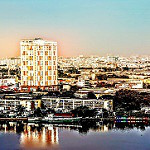

In [8]:
from tensorflow.keras.preprocessing.image import load_img

path = './Intel_Image_Classification_small/seg_train/seg_train/buildings/'
name = '9807.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [9]:
img = load_img(fullname, target_size=(299, 299))

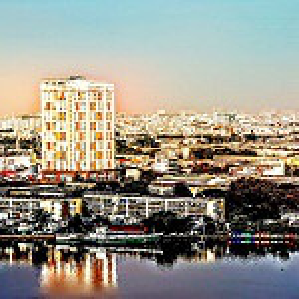

In [10]:
img

In [11]:
x = np.array(img)
x.shape

(299, 299, 3)

## Model

Train and validade the Xception model:

    
Using imagenet dataset

In [12]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    train_path,
    target_size=(DIM_SIZE, DIM_SIZE),
    batch_size=32
)

Found 7024 images belonging to 6 classes.


In [14]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    val_path,
    target_size=(DIM_SIZE, DIM_SIZE),
    batch_size=32,
    shuffle=False
)

Found 1507 images belonging to 6 classes.


# Xception

In [15]:
from tensorflow.keras.applications.xception import Xception

In [16]:
xception_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(DIM_SIZE, DIM_SIZE, 3)
)

2023-09-29 06:59:52.570550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-29 06:59:52.605487: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Training/Validating

In [17]:
import numpy as np
import scipy

In [18]:
EPOCHS = 5

In [19]:
model_dict = {'xception_model': xception_model}

In [20]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [21]:
scores = {}

def train_val_model(model_dict):

    for model_name in model_dict:
        
        base_model = model_dict[model_name]
        
        base_model.trainable = False

        inputs = keras.Input(shape=(DIM_SIZE, DIM_SIZE, 3))

        base = base_model(inputs, training=False)

        vectors = keras.layers.GlobalAveragePooling2D()(base)

        outputs = keras.layers.Dense(LAYER_NUM)(vectors)

        model = keras.Model(inputs, outputs)

        learning_rate = 0.01
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        loss = keras.losses.CategoricalCrossentropy(from_logits=True)

        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

        history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint])
        
        scores = history.history
        
    return scores

In [23]:
scores = train_val_model(model_dict)

Epoch 1/5
220/220 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8793

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 659s 3s/step - loss: 0.3252 - accuracy: 0.8793 - val_loss: 0.2506 - val_accuracy: 0.9044
Epoch 2/5
220/220 [==============================] - 656s 3s/step - loss: 0.2038 - accuracy: 0.9238 - val_loss: 0.2405 - val_accuracy: 0.9210
Epoch 3/5
220/220 [==============================] - 672s 3s/step - loss: 0.1834 - accuracy: 0.9317 - val_loss: 0.2581 - val_accuracy: 0.9111
Epoch 4/5
220/220 [==============================] - 709s 3s/step - loss: 0.1404 - accuracy: 0.9472 - val_loss: 0.2508 - val_accuracy: 0.9177
Epoch 5/5
220/220 [==============================] - 711s 3s/step - loss: 0.1381 - accuracy: 0.9479 - val_loss: 0.2579 - val_accuracy: 0.9164


In [23]:
scores.items()

dict_items([])

In [ ]:
for key, value in scores.items():
    if (key == 'val_accuracy'):
        val_accuracy = value
val_accuracy        

In [ ]:
scores.items()

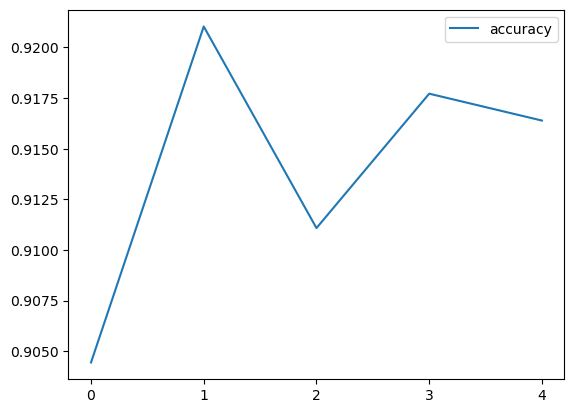

In [26]:
for key, value in scores.items():
    if (key == 'val_accuracy'):
        plt.plot(val_accuracy, label=('accuracy'))
    #plt.plot(hist['val_accuracy'], label=(f'lr={lr}'))

plt.xticks(np.arange(EPOCHS))
plt.legend()

Exception is the best model.


## Parameter Tuning

    Learning Rate
    Inner Size
    Augmentation

In [22]:
checkpoint1 = keras.callbacks.ModelCheckpoint(
    'xception2_{epoch:02d}_{val_accuracy:.4f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [23]:
def train_xception(base_model, lr=0.001, inner_size=1000):
  
    base_model.trainable = False

    inputs = keras.Input(shape=(DIM_SIZE, DIM_SIZE, 3))

    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(inner_size, activation='relu')(vectors)

    outputs = keras.layers.Dense(LAYER_NUM)(inner)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=lr)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint1])
    
    return history.history

# Learning Rate

In [ ]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    scores[lr] = train_xception(xception_model, lr)

Epoch 1/5
220/220 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.8289

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 707s 3s/step - loss: 0.6829 - accuracy: 0.8289 - val_loss: 0.3472 - val_accuracy: 0.8925
Epoch 2/5
220/220 [==============================] - 698s 3s/step - loss: 0.2946 - accuracy: 0.8985 - val_loss: 0.2697 - val_accuracy: 0.9117
Epoch 3/5
220/220 [==============================] - 693s 3s/step - loss: 0.2482 - accuracy: 0.9100 - val_loss: 0.2422 - val_accuracy: 0.9151
Epoch 4/5
220/220 [==============================] - 694s 3s/step - loss: 0.2251 - accuracy: 0.9181 - val_loss: 0.2340 - val_accuracy: 0.9164
Epoch 5/5
220/220 [==============================] - 695s 3s/step - loss: 0.2098 - accuracy: 0.9234 - val_loss: 0.2236 - val_accuracy: 0.9164
Epoch 1/5
220/220 [==============================] - 694s 3s/step - loss: 0.3144 - accuracy: 0.8865 - val_loss: 0.2569 - val_accuracy: 0.9044
Epoch 2/5
170/220 [======================>.......] - ETA: 2:09 - loss: 0.2023 - accuracy: 0.9267

In [24]:
scores = {}
for lr in [0.001, 0.01, 0.1]:
    scores[lr] = train_xception(xception_model, lr)

Epoch 1/5
220/220 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8857

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 714s 3s/step - loss: 0.3174 - accuracy: 0.8857 - val_loss: 0.2346 - val_accuracy: 0.9144
Epoch 2/5
220/220 [==============================] - 712s 3s/step - loss: 0.2015 - accuracy: 0.9263 - val_loss: 0.2426 - val_accuracy: 0.9164
Epoch 3/5
220/220 [==============================] - 713s 3s/step - loss: 0.1714 - accuracy: 0.9314 - val_loss: 0.2181 - val_accuracy: 0.9257
Epoch 4/5
220/220 [==============================] - 710s 3s/step - loss: 0.1452 - accuracy: 0.9443 - val_loss: 0.2070 - val_accuracy: 0.9250
Epoch 5/5
220/220 [==============================] - 715s 3s/step - loss: 0.1262 - accuracy: 0.9510 - val_loss: 0.2292 - val_accuracy: 0.9151
Epoch 1/5
220/220 [==============================] - 718s 3s/step - loss: 0.3357 - accuracy: 0.8769 - val_loss: 0.2467 - val_accuracy: 0.9011
Epoch 2/5
220/220 [==============================] - 711s 3s/step - loss: 0.2259 - accuracy: 0.9139 - val_loss: 0.3131 - val_accuracy: 0.8938
Epoch 3/5
220/22

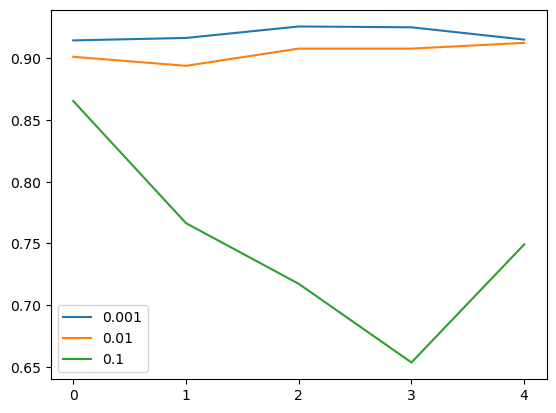

In [25]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=(lr))

plt.xticks(np.arange(EPOCHS))
plt.legend()

## Best learning rate for model : 0.001

# Inner Size

In [ ]:
# scores = {}

# for size in [10, 100, 1000]:
#     scores[size] = train_xception(xception_model, inner_size=size)

Epoch 1/5
220/220 [==============================] - 709s 3s/step - loss: 0.6789 - accuracy: 0.7454 - val_loss: 0.3948 - val_accuracy: 0.8839
Epoch 2/5
220/220 [==============================] - 694s 3s/step - loss: 0.2848 - accuracy: 0.9032 - val_loss: 0.2476 - val_accuracy: 0.9124
Epoch 3/5
220/220 [==============================] - 692s 3s/step - loss: 0.2200 - accuracy: 0.9213 - val_loss: 0.2304 - val_accuracy: 0.9151
Epoch 4/5
220/220 [==============================] - 694s 3s/step - loss: 0.1918 - accuracy: 0.9310 - val_loss: 0.2170 - val_accuracy: 0.9204
Epoch 5/5
220/220 [==============================] - 691s 3s/step - loss: 0.1743 - accuracy: 0.9361 - val_loss: 0.2407 - val_accuracy: 0.9144
Epoch 1/5
220/220 [==============================] - 693s 3s/step - loss: 0.3254 - accuracy: 0.8764 - val_loss: 0.2226 - val_accuracy: 0.9230
Epoch 2/5
220/220 [==============================] - 696s 3s/step - loss: 0.2035 - accuracy: 0.9201 - val_loss: 0.2071 - val_accuracy: 0.9224
Epoch 

In [ ]:
# scores = {}

# for size in [100, 1000]:
#     scores[size] = train_xception(xception_model, inner_size=size)

Epoch 1/5
220/220 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.8865

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 697s 3s/step - loss: 0.3206 - accuracy: 0.8865 - val_loss: 0.2282 - val_accuracy: 0.9197
Epoch 2/5
220/220 [==============================] - 695s 3s/step - loss: 0.2066 - accuracy: 0.9179 - val_loss: 0.2265 - val_accuracy: 0.9197
Epoch 3/5
220/220 [==============================] - 695s 3s/step - loss: 0.1730 - accuracy: 0.9334 - val_loss: 0.2224 - val_accuracy: 0.9184
Epoch 4/5
220/220 [==============================] - 696s 3s/step - loss: 0.1437 - accuracy: 0.9473 - val_loss: 0.2043 - val_accuracy: 0.9303
Epoch 5/5
220/220 [==============================] - 696s 3s/step - loss: 0.1273 - accuracy: 0.9527 - val_loss: 0.2148 - val_accuracy: 0.9250
Epoch 1/5
 80/220 [=========>....................] - ETA: 6:03 - loss: 0.3692 - accuracy: 0.8569

In [25]:
scores = {}

for size in [1000]:
    scores[size] = train_xception(xception_model, inner_size=size)

Epoch 1/5
220/220 [==============================] - 698s 3s/step - loss: 0.3055 - accuracy: 0.8855 - val_loss: 0.2216 - val_accuracy: 0.9190
Epoch 2/5
220/220 [==============================] - 695s 3s/step - loss: 0.1949 - accuracy: 0.9278 - val_loss: 0.2210 - val_accuracy: 0.9171
Epoch 3/5
220/220 [==============================] - 692s 3s/step - loss: 0.1569 - accuracy: 0.9391 - val_loss: 0.2324 - val_accuracy: 0.9224
Epoch 4/5
220/220 [==============================] - 694s 3s/step - loss: 0.1312 - accuracy: 0.9506 - val_loss: 0.2373 - val_accuracy: 0.9171
Epoch 5/5
220/220 [==============================] - 695s 3s/step - loss: 0.1170 - accuracy: 0.9550 - val_loss: 0.2353 - val_accuracy: 0.9230


## Best inner_size for model : 1000

# Augmentation

In [24]:
# Create image generator for train data and also augment the images
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               shear_range=10,
                               zoom_range=0.1)

train_ds = train_gen.flow_from_directory(train_path,
                                         target_size=(DIM_SIZE,DIM_SIZE),
                                         batch_size=32)

Found 7024 images belonging to 6 classes.


In [26]:
scores = []
scores = train_xception(xception_model)

Epoch 1/5
220/220 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.8548

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 680s 3s/step - loss: 0.3794 - accuracy: 0.8548 - val_loss: 0.2850 - val_accuracy: 0.8952
Epoch 2/5
220/220 [==============================] - 671s 3s/step - loss: 0.2791 - accuracy: 0.8976 - val_loss: 0.2653 - val_accuracy: 0.9018
Epoch 3/5
220/220 [==============================] - 662s 3s/step - loss: 0.2582 - accuracy: 0.9056 - val_loss: 0.2389 - val_accuracy: 0.9137
Epoch 4/5
220/220 [==============================] - 663s 3s/step - loss: 0.2292 - accuracy: 0.9117 - val_loss: 0.2578 - val_accuracy: 0.9031
Epoch 5/5
220/220 [==============================] - 668s 3s/step - loss: 0.2203 - accuracy: 0.9161 - val_loss: 0.2485 - val_accuracy: 0.9091


In [40]:

for key, value in scores.items():    
    if (key == 'val_accuracy'): 
        print (value)
        
# 'val_accuracy': [0.8951559662818909,
#   0.9017916321754456,
#   0.9137359261512756,
#   0.9031187891960144,
#   0.9090909361839294]        

[0.8951559662818909, 0.9017916321754456, 0.9137359261512756, 0.9031187891960144, 0.9090909361839294]


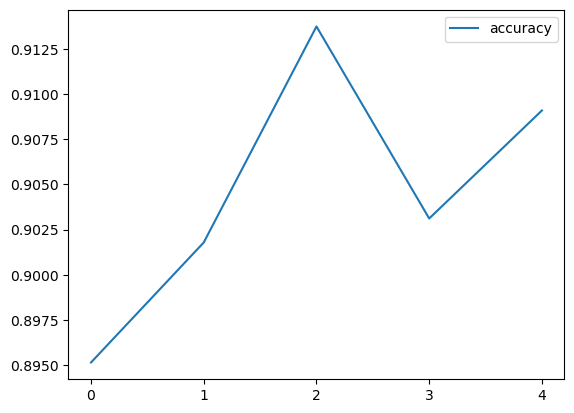

In [41]:
scores
for key, value in scores.items():    
    if (key == 'val_accuracy'):
        plt.plot(value, label=('accuracy'))

plt.xticks(np.arange(EPOCHS))
plt.legend()

## Training again for best model and saving (last time)

In [25]:
EPOCHS = 10

In [26]:
def train_xception2(base_model, lr=0.001, inner_size=1000):
  
    base_model.trainable = False

    inputs = keras.Input(shape=(DIM_SIZE, DIM_SIZE, 3))

    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(inner_size, activation='relu')(vectors)

    outputs = keras.layers.Dense(LAYER_NUM)(inner)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=lr)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [29]:
model = train_xception(xception_model)

#history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint3]) #this was a mistake

Epoch 1/10
220/220 [==============================] - 663s 3s/step - loss: 0.3935 - accuracy: 0.8528 - val_loss: 0.2650 - val_accuracy: 0.9005
Epoch 2/10
220/220 [==============================] - 657s 3s/step - loss: 0.2799 - accuracy: 0.8949 - val_loss: 0.2866 - val_accuracy: 0.8839
Epoch 3/10
220/220 [==============================] - 662s 3s/step - loss: 0.2569 - accuracy: 0.9067 - val_loss: 0.2619 - val_accuracy: 0.9058
Epoch 4/10
220/220 [==============================] - 659s 3s/step - loss: 0.2420 - accuracy: 0.9126 - val_loss: 0.2385 - val_accuracy: 0.9171
Epoch 5/10
220/220 [==============================] - 663s 3s/step - loss: 0.2249 - accuracy: 0.9166 - val_loss: 0.2325 - val_accuracy: 0.9190
Epoch 6/10
220/220 [==============================] - 660s 3s/step - loss: 0.2125 - accuracy: 0.9191 - val_loss: 0.2065 - val_accuracy: 0.9237
Epoch 7/10
220/220 [==============================] - 659s 3s/step - loss: 0.1974 - accuracy: 0.9241 - val_loss: 0.2150 - val_accuracy: 0.9244

AttributeError: 'dict' object has no attribute 'fit'

## Saved the best model 'xception2_08_0.9283.h5'